In [14]:
import numpy as np
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import json
import pandas as pd
import seaborn as sns

from collections import OrderedDict, Counter
from operator import itemgetter

from scipy.stats.stats import pearsonr
from scipy.spatial.distance import cdist
from sklearn.metrics import silhouette_score, silhouette_samples

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.ticker import PercentFormatter

plt.rcParams["figure.figsize"]=15,15


marker_types = [".", "o", "v", "^", "<",
                ">", "1", "2", "3", "4",
                "8", "s", "p", "P", "h",
                "H", "+", "x", "X", "D",
                ".", "o", "v", "^", "<", '1']

np.random.shuffle(marker_types)


ESSENTIA_DIR = "/home/lorenzo/Data/longterm_data/features/"
EMB_DIR = "../data/embeddings/{}"
TRACKS = "../data/input/random_tracklist_20220104.csv"
TRACKS_FEAT = "../data/input/tracklist_features_20220104.csv"

In [15]:
from analyze_tracks import *

In [16]:
df_tracks = pd.read_csv(TRACKS, delimiter='\t')

In [17]:
DictFeat = import_features(ESSENTIA_DIR, df_tracks)

Tracks feature found: 1444


In [18]:
embeddings, filenames = import_embeddings(EMB_DIR, 'musicnn_tsne', 2)
print("Embeddings found: {}".format(len(embeddings)))

Embeddings found: 1444


In [19]:
embeddings = np.vstack(embeddings)
emb_x = list(map(itemgetter(0), embeddings))
emb_y = list(map(itemgetter(1), embeddings))
DistMatrix = cdist(embeddings, embeddings, 'euclidean')

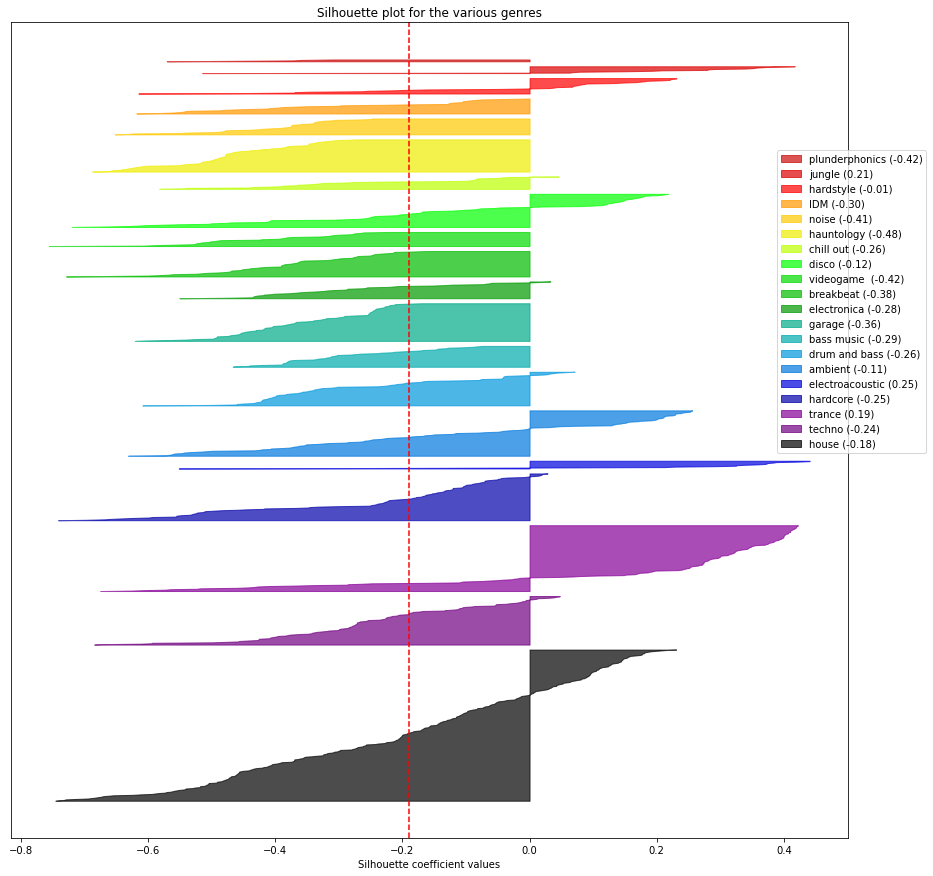

In [20]:
silhouette_analysis(DistMatrix, df_tracks, filenames)

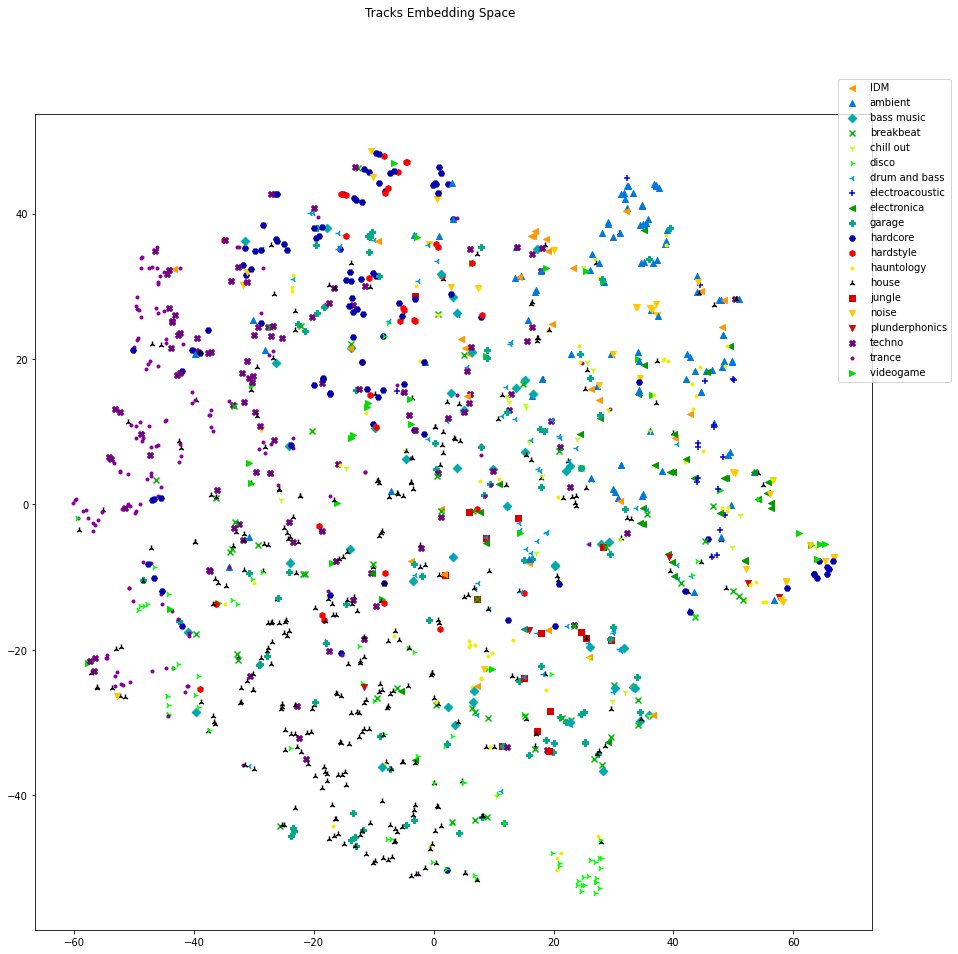

In [21]:
plot_embeddings(DistMatrix, df_tracks, emb_x, emb_y, filenames)

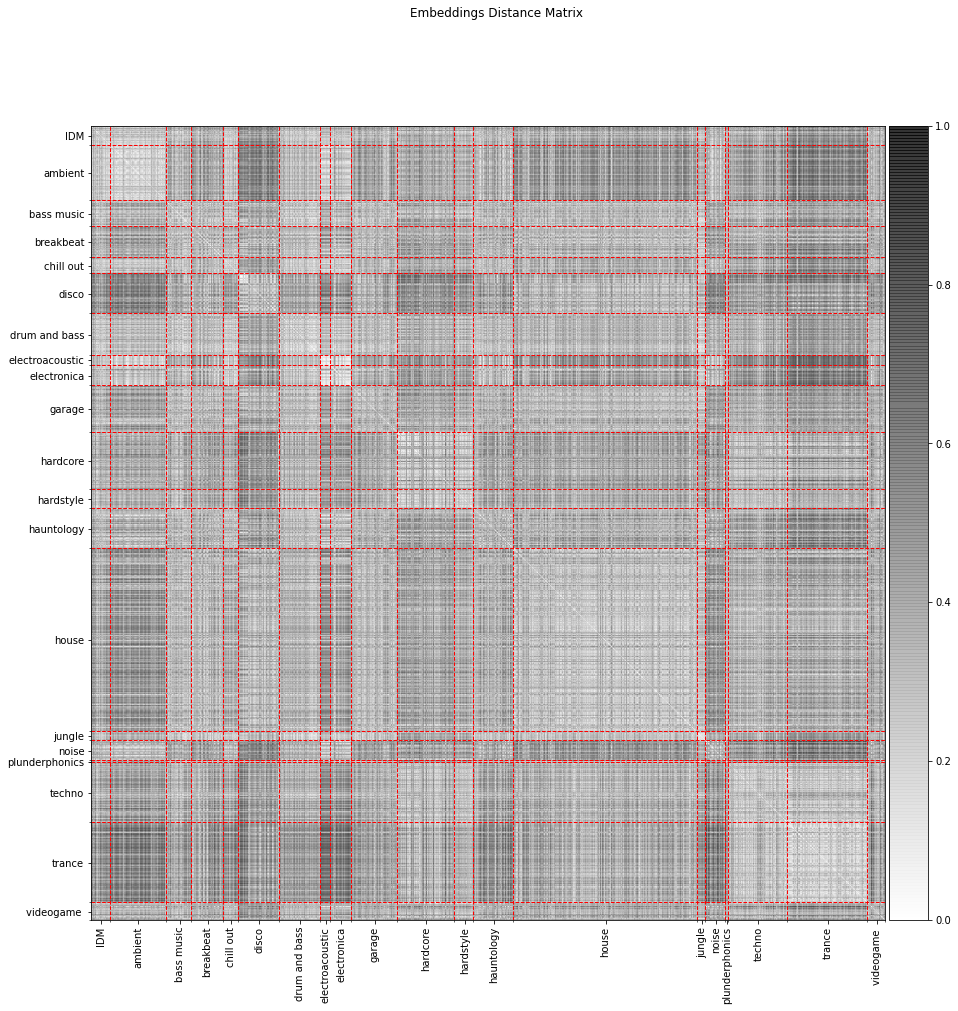

In [22]:
plot_distance_matrix(DistMatrix, df_tracks, filenames)

In [23]:
feature_correlation(DictFeat)


Computing feature correlation...
Feature bpm --> rho:0.295, p:2.149103096394059e-30
Feature dance --> rho:0.503, p:3.030729030533166e-93
Feature instr --> rho:0.416, p:1.3685282153893036e-61
Feature acoust --> rho:0.611, p:1.889373055135196e-148


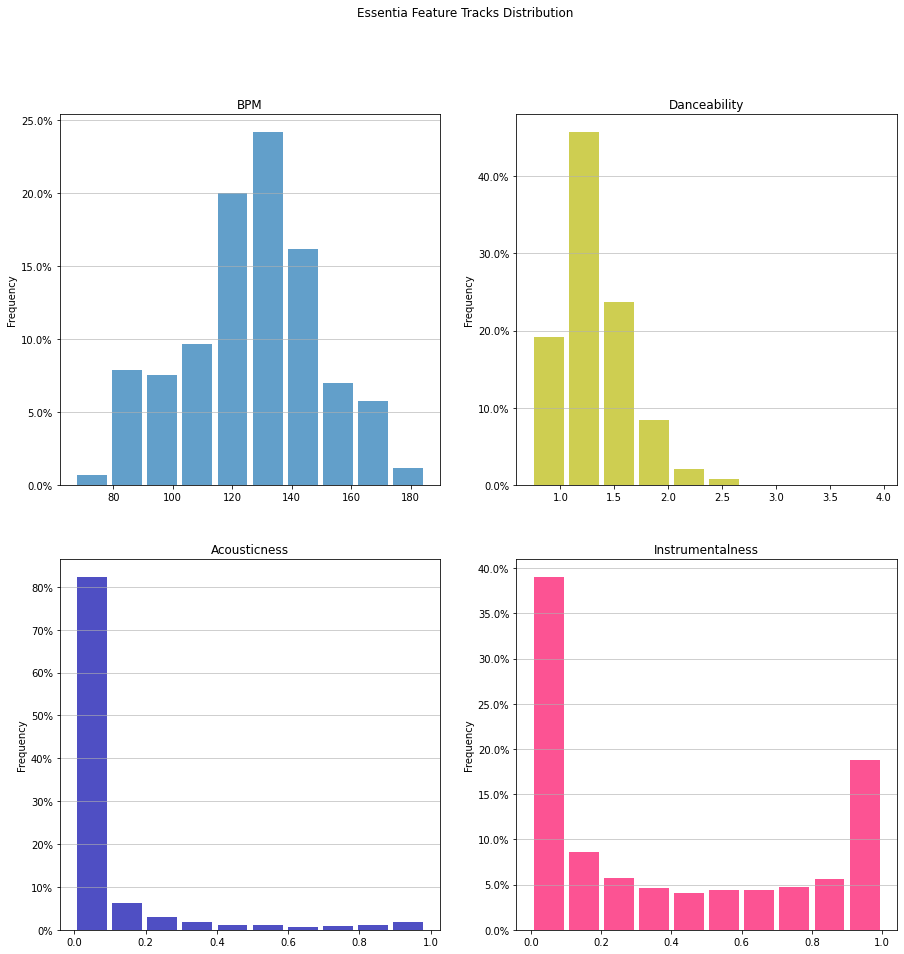

In [24]:
plot_essentia_features(DictFeat, filenames)

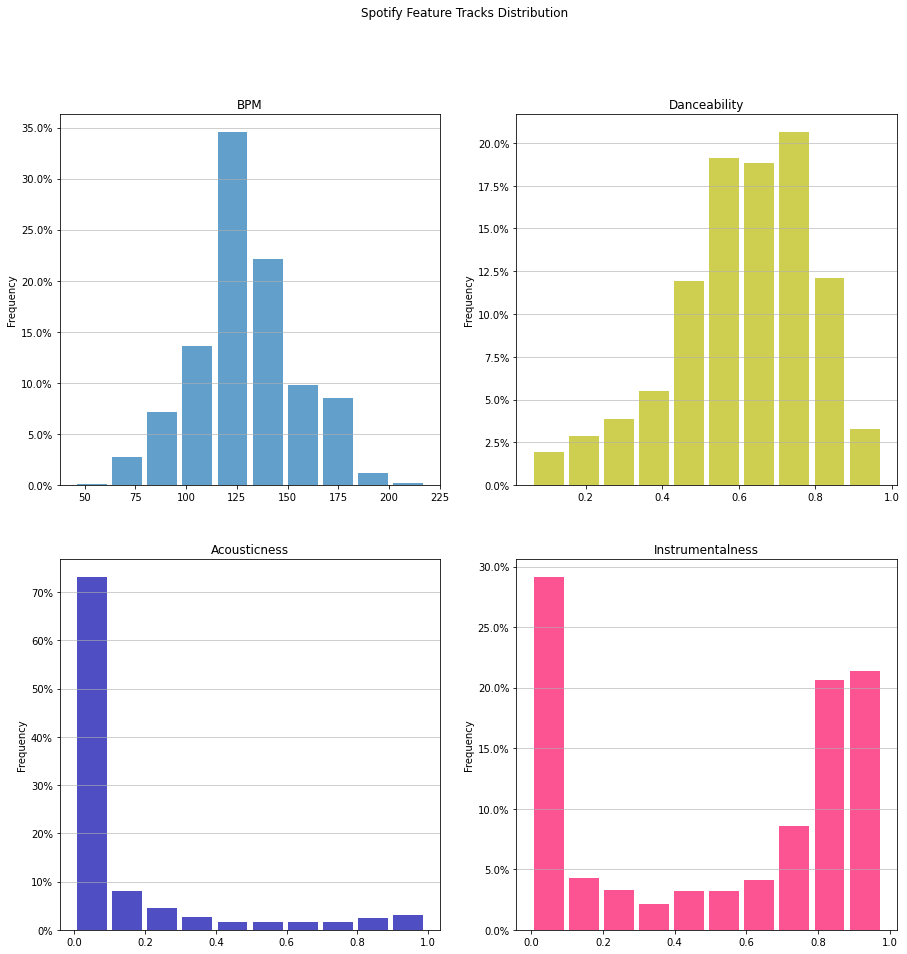

In [25]:
plot_spotify_features(DictFeat, filenames)

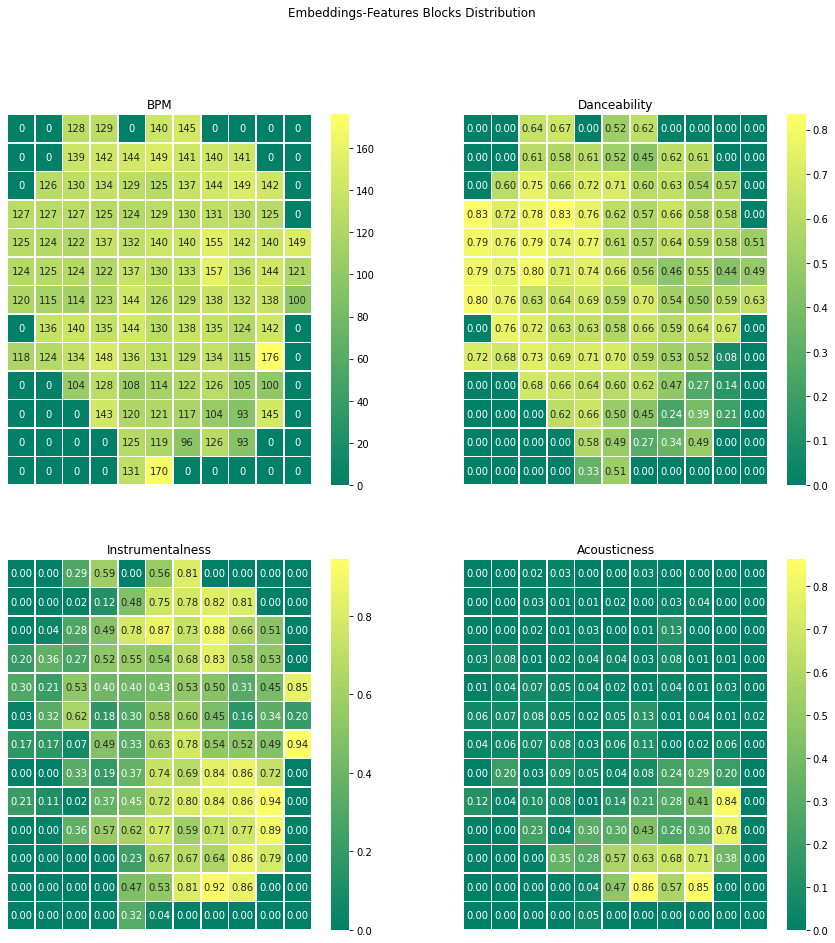

In [26]:
plot_blocks_matrix_feat(emb_x, emb_y, DictFeat, filenames)